#Import the relevant Python libraries

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

import os
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

#Read the '**Train**' dataset

In [119]:
df = pd.read_csv('/content/sample_data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [120]:
df.shape

(1460, 81)

Data Cleaning - Delete columns having only null (NA) values

In [121]:
# Check how many columns have all null(NA) values
null_cols = df.columns[df.isna().all()]
null_cols.size # Result No columns to delete

0

# Null value imputation to be done for these fields
LotFrontage , numeric, NA to zero(0).

MasVnrArea , numeric, NA to zero(0).

GarageYrBlt, numeric, NA to median.





In [122]:
print(df.LotFrontage[df.LotFrontage.isna()].size)
df.LotFrontage[df.LotFrontage.isna()] = 0
df.LotFrontage[df.LotFrontage.isna()].size

259


0

In [123]:
print(df.MasVnrArea[df.MasVnrArea.isna()].size)
df.MasVnrArea[df.MasVnrArea.isna()] = 0
df.MasVnrArea[df.MasVnrArea.isna()].size

8


0

In [124]:
print(df.GarageYrBlt[df.GarageYrBlt.isna()].size)
df.GarageYrBlt[df.GarageYrBlt.isna()] = df.GarageYrBlt.median()
df.GarageYrBlt[df.GarageYrBlt.isna()].size

81


0

#Remove the column
id can be removed since it is just an id value

PoolQC has 1453/1460 records as zero(0).

PoolArea has 1453/1460 records as zero(0).

MiscVal has 1408/1460 records as zero(0).

MiscFeature has 1453/1460 records as NA.

ScreenPorch has 1344/1460 records as zero(0).

3SsnPorch has 1436/1460 records as zero(0).

EnclosedPorch has 1252/1460 records as zero(0).

Utilities has only 2 values and one of them is 1459/1460.

LandSlope has 1382/1460 records as zero(0).

Condition2 has 1445/1460 records for one value "Norm"

RoofMatl has 1434/1460 records for one value "CompShg"

***All these columns have the values as NA or zero(0) for more than 80% of the records. Hence remove these columns as these values would not affect the consideration.***

In [125]:
#Remove the column
removecols = ['Id', 'PoolQC', 'PoolArea', 'MiscVal', 'MiscFeature', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl']
df.drop(removecols, axis=1, inplace=True)
df.shape # Result (1460, 69)

(1460, 69)

### Remove the numerical variables that are least correlated with the target variable 'SalePrice'

In [126]:
# Select only numeric columns from the dataframe
df_numeric = df.select_dtypes(include='number')
vars_to_scale = df_numeric.columns


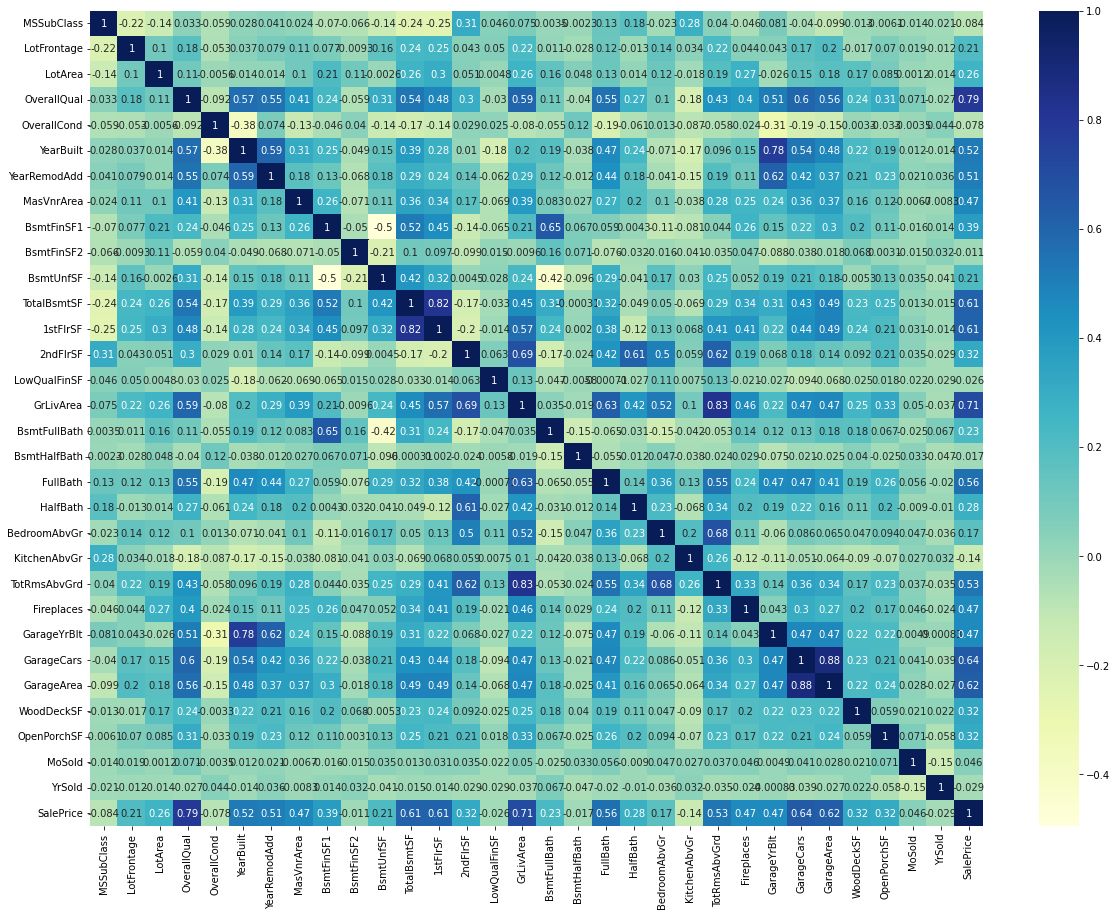

In [127]:
# To perform linear regression, the (numeric) target variable should be linearly related to at least one another numeric variable.
# Visualise the numeric variables

plt.figure(figsize = (20,15))
sbn.heatmap(df.corr(), cmap="YlGnBu", annot = True)
plt.show()

In [128]:
removecols = []
for col in df_numeric.columns:
  if col != 'SalePrice':
    # print(col + "-" + 'SalePrice')
    # df_col = df[[col,'SalePrice']]
    cor = df[col].corr(df['SalePrice'])
    if (cor > -0.1) and (cor < 0.1) :
      # print('Correlation for ' + col + "-" + 'SalePrice' + ' is ', cor)
      removecols.append(col)


In [129]:
print(removecols)
df.drop(removecols, axis=1, inplace=True)
print(df.shape) # Result (1460, 62)

df_numeric = df.select_dtypes(include='number')
vars_to_scale = df_numeric.columns
print(vars_to_scale.size)

['MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'MoSold', 'YrSold']
(1460, 62)
25


# Creating dummy variables for categorical variables

In [130]:
df_dependent = df['SalePrice']
df.drop('SalePrice', axis = 1, inplace=True)

In [131]:
# Select only numeric columns from the dataframe
df_categorical = df.select_dtypes(include='object')
categorical_vars = df_categorical.columns
df_categorical.shape


(1460, 37)

In [132]:
categorical_dummies = pd.get_dummies(df_categorical, drop_first=True)
categorical_dummies.head()
categorical_dummies.shape

(1460, 187)

In [133]:
# Drop categorical variables 
df.drop(list(df_categorical.columns), axis=1, inplace=True)
df.shape

(1460, 24)

In [134]:
# Concat the dummy variables with df
df = pd.concat([df, categorical_dummies], axis=1)
df.shape

(1460, 211)

In [135]:
# Add the target variable at the end
df = pd.concat([df, df_dependent], axis = 1)
df.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,65.0,8450,7,2003,2003,196.0,706,150,856,856,...,0,0,0,1,0,0,0,1,0,208500
1,80.0,9600,6,1976,1976,0.0,978,284,1262,1262,...,0,0,0,1,0,0,0,1,0,181500
2,68.0,11250,7,2001,2002,162.0,486,434,920,920,...,0,0,0,1,0,0,0,1,0,223500
3,60.0,9550,7,1915,1970,0.0,216,540,756,961,...,0,0,0,1,0,0,0,0,0,140000
4,84.0,14260,8,2000,2000,350.0,655,490,1145,1145,...,0,0,0,1,0,0,0,1,0,250000


In [136]:
#Collect the non numeric columns again
print(categorical_dummies.shape)
print(df.shape)
remove_categorical_dummies = []
for col in categorical_dummies.columns:
  if col != 'SalePrice':
    # print(col + "-" + 'SalePrice')
    # df_col = df[[col,'SalePrice']]
    cor = df[col].corr(df['SalePrice'])
    if (cor > -0.1) and (cor < 0.1) :
      remove_categorical_dummies.append(col)

(1460, 187)
(1460, 212)


In [137]:
print(remove_categorical_dummies)
df.drop(remove_categorical_dummies, axis=1, inplace=True)
df.shape # Result (1460, 107)


['MSZoning_FV', 'MSZoning_RH', 'Street_Pave', 'Alley_Pave', 'LotShape_IR3', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'Neighborhood_Blueste', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Gilbert', 'Neighborhood_Mitchel', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_SWISU', 'Neighborhood_SawyerW', 'Neighborhood_Veenker', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'BldgType_2fmCon', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_W

(1460, 107)

In [138]:
# Visualise the variables
plt.figure(figsize = (30,20))
# sbn.heatmap(df.corr(), cmap="YlGnBu", annot = True)
plt.show()

<Figure size 2160x1440 with 0 Axes>

## Splitting the Data into Training and Testing Sets

In [139]:
#Split the dataset into train and test
from sklearn.model_selection import train_test_split

np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [140]:
df_train.shape
#(1021, 107)

(1021, 107)

In [141]:
df_test.shape
#(438, 107)

(438, 107)

# Rescaling: Use the MinMax scaling for this data

In [142]:
scaler = MinMaxScaler()

# Apply scaler to only the continuous(numeric) variables including the target variable
scale_vars = df_numeric.columns
df_train[scale_vars] = scaler.fit_transform(df_train[scale_vars])
df_train.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageCond_Fa,GarageCond_TA,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,SaleType_New,SaleType_WD,SaleCondition_Normal,SaleCondition_Partial,SalePrice
210,0.214058,0.019306,0.444444,0.384058,0.000000,0.00,0.082920,0.169521,0.141408,0.113889,...,0,0,1,0,0,0,1,1,0,0.087627
318,0.287540,0.039403,0.666667,0.876812,0.716667,0.16,0.174876,0.154110,0.220458,0.231481,...,0,1,1,0,0,0,1,1,0,0.312595
239,0.166134,0.033981,0.555556,0.528986,0.000000,0.00,0.016655,0.274401,0.120295,0.098611,...,0,1,1,0,1,0,1,1,0,0.108457
986,0.188498,0.017931,0.555556,0.275362,0.883333,0.00,0.000000,0.207620,0.079378,0.145602,...,0,1,1,0,0,0,1,1,0,0.114012
1416,0.191693,0.046139,0.333333,0.094203,0.000000,0.00,0.000000,0.332620,0.127169,0.202315,...,0,1,0,0,0,0,1,1,0,0.121650


In [143]:
df_train.describe()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageCond_Fa,GarageCond_TA,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,SaleType_New,SaleType_WD,SaleCondition_Normal,SaleCondition_Partial,SalePrice
count,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,...,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000
mean,0.183970,0.042143,0.565676,0.719215,0.582305,0.065306,0.079337,0.241388,0.173773,0.184341,...,0.025465,0.905975,0.915769,0.032321,0.104799,0.078355,0.870715,0.825661,0.078355,0.202113
std,0.109910,0.048226,0.155529,0.219897,0.343843,0.117088,0.082377,0.192066,0.075145,0.092132,...,0.157611,0.292007,0.277870,0.176939,0.306445,0.268860,0.335680,0.379587,0.268860,0.109835
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.137380,0.027923,0.444444,0.594203,0.283333,0.000000,0.000000,0.092466,0.129787,0.116435,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.131371
50%,0.191693,0.037531,0.555556,0.731884,0.733333,0.000000,0.069454,0.197774,0.162357,0.165278,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.173726
75%,0.249201,0.046943,0.666667,0.927536,0.900000,0.098750,0.126152,0.345034,0.215057,0.243056,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.248715
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


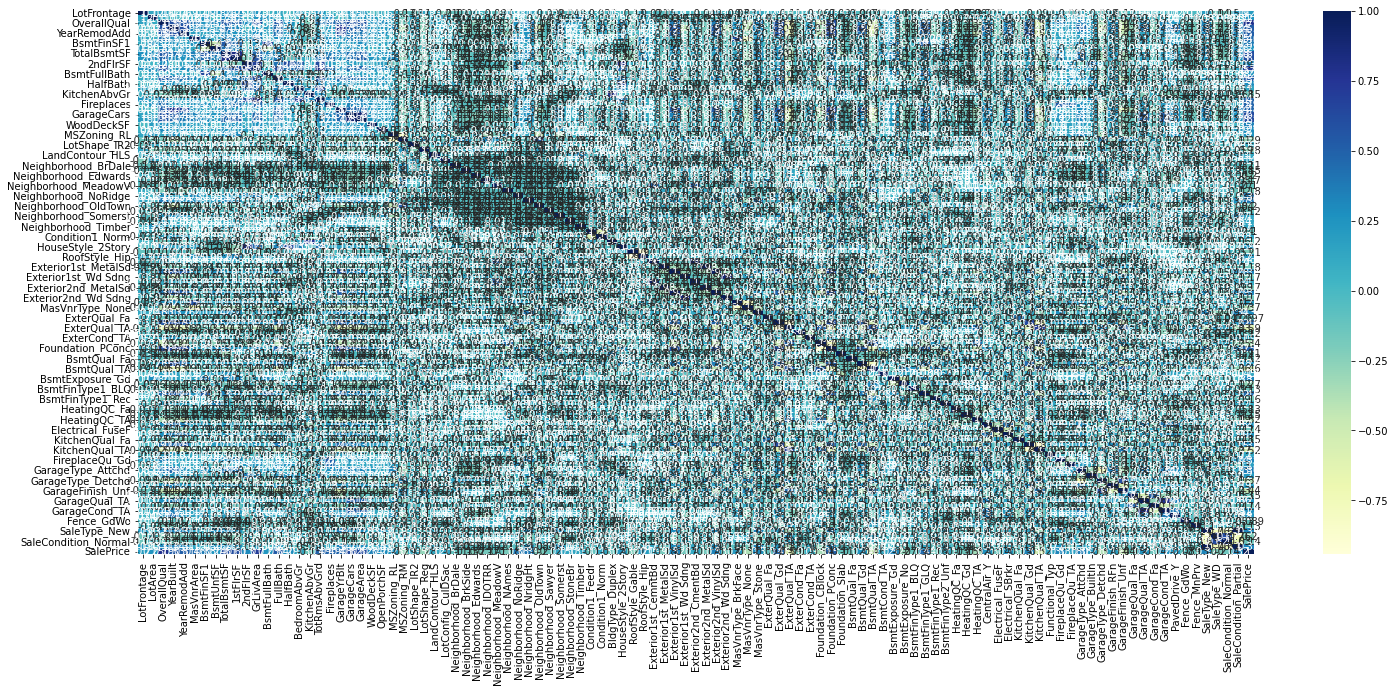

In [144]:
# Check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (25, 10))
sbn.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [145]:
# Scale the test dataset
# Apply scaler to only the continuous(numeric) variables including the target variable
scale_vars = df_numeric.columns
df_test[scale_vars] = scaler.transform(df_test[scale_vars])
df_test.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageCond_Fa,GarageCond_TA,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,SaleType_New,SaleType_WD,SaleCondition_Normal,SaleCondition_Partial,SalePrice
1436,0.191693,0.035192,0.333333,0.717391,0.350000,0.00000,0.109142,0.106164,0.141408,0.113889,...,0,1,1,1,0,0,1,1,0,0.118872
57,0.284345,0.047566,0.666667,0.956522,0.900000,0.00000,0.000000,0.368151,0.140753,0.112963,...,0,1,1,0,0,0,1,1,0,0.224413
780,0.201278,0.029930,0.666667,0.891304,0.766667,0.02375,0.000000,0.529538,0.202455,0.203935,...,0,1,1,0,0,0,1,1,0,0.195945
382,0.252396,0.036338,0.666667,0.971014,0.933333,0.00000,0.000000,0.401969,0.153682,0.131250,...,0,1,1,0,0,0,1,1,0,0.248021
1170,0.242812,0.039309,0.555556,0.760870,0.450000,0.00000,0.092488,0.245719,0.179378,0.172685,...,0,1,1,0,0,0,1,1,0,0.189002


# Model Building and Evaluation

# Linear Regression

In [146]:
lm = LinearRegression()

In [147]:
# Divide X and y train sets for model building
y_train = df_train.pop('SalePrice')
y_train.head()
X_train = df_train
X_train.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageQual_TA,GarageCond_Fa,GarageCond_TA,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,SaleType_New,SaleType_WD,SaleCondition_Normal,SaleCondition_Partial
210,0.214058,0.019306,0.444444,0.384058,0.000000,0.00,0.082920,0.169521,0.141408,0.113889,...,0,0,0,1,0,0,0,1,1,0
318,0.287540,0.039403,0.666667,0.876812,0.716667,0.16,0.174876,0.154110,0.220458,0.231481,...,1,0,1,1,0,0,0,1,1,0
239,0.166134,0.033981,0.555556,0.528986,0.000000,0.00,0.016655,0.274401,0.120295,0.098611,...,1,0,1,1,0,1,0,1,1,0
986,0.188498,0.017931,0.555556,0.275362,0.883333,0.00,0.000000,0.207620,0.079378,0.145602,...,0,0,1,1,0,0,0,1,1,0
1416,0.191693,0.046139,0.333333,0.094203,0.000000,0.00,0.000000,0.332620,0.127169,0.202315,...,1,0,1,0,0,0,0,1,1,0


In [148]:
# Divide X and y test sets for model building
y_test = df_test.pop('SalePrice')
y_test.head()
X_test = df_test
X_test.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageQual_TA,GarageCond_Fa,GarageCond_TA,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,SaleType_New,SaleType_WD,SaleCondition_Normal,SaleCondition_Partial
1436,0.191693,0.035192,0.333333,0.717391,0.350000,0.00000,0.109142,0.106164,0.141408,0.113889,...,1,0,1,1,1,0,0,1,1,0
57,0.284345,0.047566,0.666667,0.956522,0.900000,0.00000,0.000000,0.368151,0.140753,0.112963,...,1,0,1,1,0,0,0,1,1,0
780,0.201278,0.029930,0.666667,0.891304,0.766667,0.02375,0.000000,0.529538,0.202455,0.203935,...,1,0,1,1,0,0,0,1,1,0
382,0.252396,0.036338,0.666667,0.971014,0.933333,0.00000,0.000000,0.401969,0.153682,0.131250,...,1,0,1,1,0,0,0,1,1,0
1170,0.242812,0.039309,0.555556,0.760870,0.450000,0.00000,0.092488,0.245719,0.179378,0.172685,...,1,0,1,1,0,0,0,1,1,0


In [149]:
# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [150]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

0.03261042030341196
[-1.08457848e-02  9.17019156e-02  1.14218693e-01 -2.15781340e-02
  1.67183015e-02  3.32156587e-02 -1.05520706e-01 -4.14544828e-02
  1.37081874e-01  4.08765067e-01  2.13070803e-01 -1.77528116e-01
  3.64842136e-02  2.89358547e-02  8.42225045e-03  6.30353978e-03
 -7.41029868e-02  2.72313688e-02  1.79096076e-02 -1.77452208e-02
  7.74845453e-02 -1.26949302e-02  1.48559118e-02 -1.77081876e-02
  1.81989136e-02  6.63577126e-03  5.13095786e-03  7.28802667e-04
  1.14809761e-02  1.37903117e-02 -1.61310755e-02 -5.65069954e-03
 -3.71568101e-02 -2.05715698e-02 -3.08206364e-02 -1.39912337e-02
  7.81671358e-02  4.31689164e-02 -2.24145155e-02 -1.36694542e-02
  4.38581058e-02  2.61592103e-02 -1.22568155e-02 -6.32466289e-03
  1.67465879e-02 -3.30240116e-03 -2.11528133e-02 -5.92363418e-03
 -4.81808393e-03 -1.45123609e-02 -1.17984835e-02 -8.73281148e-03
 -3.89268268e-03  2.29251253e-02  1.10215736e-02  2.20785652e-02
  4.77046531e-03  1.80609468e-03  1.10689372e-02 -2.73061630e-03
 -9.8

In [151]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.8714726083135973
-2.574888246496364e+23
1.5815332122597439
1.3996632155968914e+24
0.0015490041256216885
3.195578117801122e+21


# Ridge and Lasso Regression

In [152]:
from sklearn.preprocessing import PolynomialFeatures

In [153]:
# Get the model coefficients for specific lambda say 0.001

# Ridge Regression
lambda_val = 0.001
degree = 1
ridgecoef = PolynomialFeatures(degree, include_bias = True)
# Transforming input features to polynomial features (1)    
X_train_poly = ridgecoef.fit_transform(X_train)
ridgereg = Ridge(alpha = lambda_val) # Initialize the Ridge Regression model with a specific lambda
ridgereg.fit(X_train_poly, y_train) # fit the model on the polynomial features
print(ridgereg.coef_)    
y_train_pred = ridgereg.predict(ridgecoef.fit_transform(X_train))
print("r2 score = " + str(r2_score(y_train, y_train_pred)))

# Lasso Regression
lassocoef = PolynomialFeatures(degree)
# Transforming input features to polynomial features 
X_train_poly = lassocoef.fit_transform(X_train)
lassoreg = Lasso(alpha = lambda_val)
lassoreg.fit(X_train_poly, y_train)
print(lassoreg.coef_)
y_train_pred = lassoreg.predict(lassocoef.fit_transform(X_train))
print("r2 score = " + str(r2_score(y_train, y_train_pred)))


[ 0.         -0.01089001  0.0912909   0.11417472 -0.02168165  0.01646725
  0.03296829 -0.1018948  -0.04022481  0.13450427  0.40439713  0.21103541
 -0.17308321  0.03621749  0.02886536  0.00890708  0.00657786 -0.07393546
  0.02709905  0.01811864 -0.01767727  0.07710726 -0.0123657   0.01495549
 -0.01761924  0.01833261  0.00697274  0.00511617  0.00071832  0.01157394
  0.01390004 -0.01627607 -0.00568398 -0.03691069 -0.0203902  -0.03137636
 -0.01388067  0.07834867  0.043274   -0.0223505  -0.01358865  0.04375265
  0.02609814 -0.0124325  -0.00620956  0.016849   -0.00330583 -0.0211491
 -0.00594617 -0.0047757  -0.01510057 -0.01176597 -0.00850832 -0.0041786
  0.02379487  0.01106736  0.02201553  0.00497199  0.00162356  0.01090741
 -0.00289521 -0.00953372 -0.0050144  -0.0126186  -0.00867554 -0.00287015
  0.01533804  0.00425737 -0.00862756 -0.02850127 -0.03962666 -0.03276011
  0.00780838  0.02730476 -0.00850105  0.00910858  0.00856929  0.0028138
  0.00998169  0.00077532 -0.00385651 -0.00498001  0.00

### R-Squared for Ridge is r2 score = 0.8714738976481304

### R-Squared for Lasso is r2 score = 0.820261488454567

This is the best value for Lambda. Higher polynomial values reduce the R-Squared for Lasso to zero (0).

### Ridge and Lasso with Double the value (0.001 to 0.002)

In [154]:
# Get the model coefficients for specific lambda say 0.002

# Ridge Regression
lambda_val = 0.002
degree = 1
ridgecoef = PolynomialFeatures(degree, include_bias = True)
# Transforming input features to polynomial features (1)    
X_train_poly = ridgecoef.fit_transform(X_train)
ridgereg = Ridge(alpha = lambda_val) # Initialize the Ridge Regression model with a specific lambda
ridgereg.fit(X_train_poly, y_train) # fit the model on the polynomial features
print(ridgereg.coef_)    
y_train_pred = ridgereg.predict(ridgecoef.fit_transform(X_train))
print("r2 score = " + str(r2_score(y_train, y_train_pred)))

# Lasso Regression
lassocoef = PolynomialFeatures(degree)
# Transforming input features to polynomial features 
X_train_poly = lassocoef.fit_transform(X_train)
lassoreg = Lasso(alpha = lambda_val)
lassoreg.fit(X_train_poly, y_train)
print(lassoreg.coef_)
y_train_pred = lassoreg.predict(lassocoef.fit_transform(X_train))
print("r2 score = " + str(r2_score(y_train, y_train_pred)))

[ 0.         -0.01093143  0.09123944  0.11419147 -0.02155376  0.01646879
  0.03297167 -0.1009626  -0.03985022  0.13364118  0.39732073  0.20767932
 -0.1648046   0.03622904  0.02886579  0.0089339   0.00657748 -0.07385676
  0.02704678  0.0181301  -0.01773442  0.07710976 -0.01233485  0.01496545
 -0.01759828  0.01835269  0.00697694  0.0051236   0.00071678  0.01158613
  0.01389589 -0.01625594 -0.00563892 -0.03685986 -0.0203486  -0.03136349
 -0.01386232  0.07836779  0.04327951 -0.02228695 -0.01356776  0.04376141
  0.02609825 -0.01242176 -0.00621688  0.01684779 -0.00330134 -0.02112735
 -0.00597433 -0.00479292 -0.01503781 -0.01174836 -0.0084794  -0.00414649
  0.02374444  0.01103417  0.02198425  0.00494357  0.00160957  0.01089241
 -0.00291226 -0.00970307 -0.00503236 -0.0126227  -0.00873966 -0.00287885
  0.0153285   0.00424462 -0.00863776 -0.02847427 -0.03961191 -0.03274996
  0.00781841  0.02731197 -0.00851019  0.0091116   0.00855308  0.0028222
  0.00992443  0.00075511 -0.00385947 -0.00498942  0.

### R-Squared for Ridge is r2 score = 0.8714726405946631

### R-Squared for Lasso is r2 score = 0.77195129513867

When the value is doubled it is noted that the R-Squared of Lasso has reduced more but the value of Ridge is almost same.